In [37]:
import numpy as np
from torchvision.datasets import MNIST
from scipy.special import expit
import matplotlib.pyplot as plt
import subprocess

In [38]:
class MLP:
    def __init__(
        self, num_input_node, num_hidden_node, num_output_node, learning_rate=0.01
    ):
        """initialize the multi-layer perceptron

        Args:
            num_input_node: number of input nodes
            num_hidden_node: number of hidden nodes
            num_output_node: number of output nodes
            learning_rate: learning rate. Defaults to 0.01
        """
        self.num_input_node = num_input_node
        self.num_hidden_node = num_hidden_node
        self.num_output_node = num_output_node

        # Initialize the weights
        self.wih = np.random.normal(
            0.0,
            pow(self.num_hidden_node, -0.5),
            (self.num_hidden_node, self.num_input_node),
        )
        self.who = np.random.normal(
            0,
            pow(self.num_output_node, -0.5),
            (self.num_output_node, self.num_hidden_node),
        )

        self.lr = learning_rate
        self.activation_function = lambda x: expit(x)

    def predict(self, input_item):
        """predict the output of the neural network

        Args:
            inputs: input data
        """
        out_hidden = self.activation_function(np.dot(self.wih, input_item))
        out_output = self.activation_function(np.dot(self.who, out_hidden))

        ground_truth = np.argmax(out_output)
        return ground_truth

    def train(self, input, label, iter_nums=20):
        """train the neural network using input data and label

        Args:
            input: input data
            label: label
            iter_nums (int, optional): train iteration counts. Defaults to 10.
        """
        # correct_cnt = 0
        for i in range(iter_nums):
            # step 1: predict the output
            out_hidden = self.activation_function(np.dot(self.wih, input))
            out_output = self.activation_function(np.dot(self.who, out_hidden))

            # step 2: compute the error
            error_output = label - out_output
            error_hidden = np.dot(self.who.T, error_output)

            # step 3: update the weights
            self.who += self.lr * np.dot(
                (error_output * out_output * (1.0 - out_output)),
                np.transpose(out_hidden),
            )
            self.wih += self.lr * np.dot(
                (error_hidden * out_hidden * (1.0 - out_hidden)), np.transpose(input)
            )

            # calculate the correct radix
            # ground_truth = np.argmax(out_output)
            # label_val = np.where(label == 1)[0][0]
            # if ground_truth == label_val:
            # correct_cnt += 1

            # if i % 49 == 0:
            #     print(
            #         f"iteration {i} label:{label_val} ground truth:{ ground_truth}, Correct: {label_val == ground_truth}"
            #     )
        # print(f"correct radix is {correct_cnt / iter_nums}")

    def evaluate_model(self, test_data):
        """Evaluate the MLP model on test_data.

        Args:
            test_data (list): List of test samples where each sample is a tuple (input, label).

        Returns:
            accuracy (float): Accuracy of the model on the test dataset.
            average_loss (float): Average loss of the model on the test dataset.
        """
        correct_predictions = 0
        total_loss = 0
        num_samples = len(test_data)

        for _, sample in enumerate(test_data):
            input_data, true_label = sample
            input_data = np.array(input_data) / 255.0
            input_data = input_data.reshape(28 * 28, 1)

            # Forward pass
            hidden_output = self.activation_function(np.dot(self.wih, input_data))
            final_output = self.activation_function(np.dot(self.who, hidden_output))

            # Predict the label
            predicted_label = self.predict(input_data)

            # Check if the prediction is correct
            if predicted_label == true_label:
                correct_predictions += 1

            # Create a one-hot encoded vector for the true label
            true_label_one_hot = np.zeros(final_output.shape)
            true_label_one_hot[true_label] = 1

            # Compute the loss for this sample
            sample_loss = -np.sum(true_label_one_hot * np.log(final_output))
            total_loss += sample_loss

        # Calculate average loss and accuracy
        average_loss = total_loss / num_samples
        accuracy = correct_predictions / num_samples

        # print(f"Accuracy: {accuracy:.4f}")
        # print(f"Average Loss: {average_loss:.4f}")

        return accuracy, average_loss

In [39]:
# Load the MNIST dataset
train_data = MNIST(root="data", train=True, download=True)
test_data = MNIST(root="data", train=False, download=True)
train_list = list(train_data)
test_list = list(test_data)

In [40]:
def train_mlp(lr):
    num_input_node = 28 * 28
    num_hidden_node = 80
    num_output_node = 10

    mlp_model = MLP(num_input_node, num_hidden_node, num_output_node, lr)

    train_accuracy_list = []
    test_accuracy_list = []
    train_loss_list = []
    test_loss_list = []
    iteration_list = []

    # train only one train sample during a train epoch
    for i, item in enumerate(train_list):
        input = np.array(item[0])
        # Normalize the input because the input is the pixel value of the image, and the activation function is sigmoid
        input = (input / 255.0).reshape(28 * 28, 1)
        label = np.zeros((10, 1))
        label[item[1]] = 1

        mlp_model.train(input, label)

        # evaluate the model every 100 iterations
        if i % 100 == 0:
            train_accuracy, train_loss = mlp_model.evaluate_model(train_list)
            test_accuracy, test_loss = mlp_model.evaluate_model(test_list)

            train_accuracy_list.append(train_accuracy)
            test_accuracy_list.append(test_accuracy)
            train_loss_list.append(train_loss)
            test_loss_list.append(test_loss)
            iteration_list.append(i)

            print(
                f"•----- lr {lr:<5} Iteration {i:<5} ----- Train Accuracy: {train_accuracy:<6.2f} ----- Test Accuracy: {test_accuracy:<6.2f} ----- Train Loss: {train_loss:<6.2f} ----- Test Loss: {test_loss:<6.2f} -----•"
            )

    # visualize the accuracy plot
    plt.figure(figsize=(10, 6))
    plt.plot(
        iteration_list,
        train_accuracy_list,
        label="Training Accuracy",
        color="blue",
        linestyle="-",
        linewidth=2,
    )
    plt.plot(
        iteration_list,
        test_accuracy_list,
        label="Testing Accuracy",
        color="green",
        linestyle="--",
        linewidth=2,
    )
    plt.ylim(0, 1)
    plt.xlabel("Iterations", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.title(f"Training and Testing Accuracy (Learning Rate: {lr})", fontsize=16)
    plt.legend(loc="best")
    plt.grid(True)
    
    # save the plot as svg and emf 
    svg_path_accuracy = f"./images/mnist_train_lr{lr}_accuracy_plot.svg"
    emf_path_accuracy = f"./images/mnist_train_lr{lr}_accuracy_plot.emf"
    plt.savefig(svg_path_accuracy)
    subprocess.run(
        f"inkscape --export-filename={emf_path_accuracy} {svg_path_accuracy}",
        shell=True,
    )
    
    plt.show()

    # visualize the loss plot
    plt.figure(figsize=(10, 6))
    plt.plot(
        iteration_list,
        train_loss_list,
        label="Training Loss",
        color="red",
        linestyle="-",
        linewidth=2,
    )
    plt.plot(
        iteration_list,
        test_loss_list,
        label="Testing Loss",
        color="orange",
        linestyle="--",
        linewidth=2,
    )
    plt.ylim(0, max(max(train_loss_list), max(test_loss_list)) * 1.1)
    plt.xlabel("Iterations", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.title(f"Training and Testing Loss (Learning Rate: {lr})", fontsize=16)
    plt.legend(loc="best")
    plt.grid(True)

    svg_path_loss = f"./images/mnist_train_lr{lr}_loss_plot.svg"
    emf_path_loss = f"./images/mnist_train_lr{lr}_loss_plot.emf"
    plt.savefig(svg_path_loss)
    subprocess.run(
        f"inkscape --export-filename={emf_path_loss} {svg_path_loss}", shell=True
    )
    plt.show()

•----- lr 0.001 Iteration 0     ----- Train Accuracy: 0.10   ----- Test Accuracy: 0.10   ----- Train Loss: 0.99   ----- Test Loss: 1.00   -----•
•----- lr 0.001 Iteration 100   ----- Train Accuracy: 0.37   ----- Test Accuracy: 0.36   ----- Train Loss: 1.74   ----- Test Loss: 1.76   -----•
•----- lr 0.001 Iteration 200   ----- Train Accuracy: 0.56   ----- Test Accuracy: 0.56   ----- Train Loss: 1.54   ----- Test Loss: 1.55   -----•
•----- lr 0.001 Iteration 300   ----- Train Accuracy: 0.61   ----- Test Accuracy: 0.61   ----- Train Loss: 1.42   ----- Test Loss: 1.44   -----•
•----- lr 0.001 Iteration 400   ----- Train Accuracy: 0.65   ----- Test Accuracy: 0.66   ----- Train Loss: 1.30   ----- Test Loss: 1.30   -----•
•----- lr 0.001 Iteration 500   ----- Train Accuracy: 0.68   ----- Test Accuracy: 0.69   ----- Train Loss: 1.22   ----- Test Loss: 1.23   -----•
•----- lr 0.001 Iteration 600   ----- Train Accuracy: 0.72   ----- Test Accuracy: 0.73   ----- Train Loss: 1.15   ----- Test Loss:


** (org.inkscape.Inkscape:25395): WARNING **: 15:56:36.217: Duplicate option text ('RGBA 8') for parameter 'png_bitdepth' in extension 'org.inkscape.output.png.inkscape'.


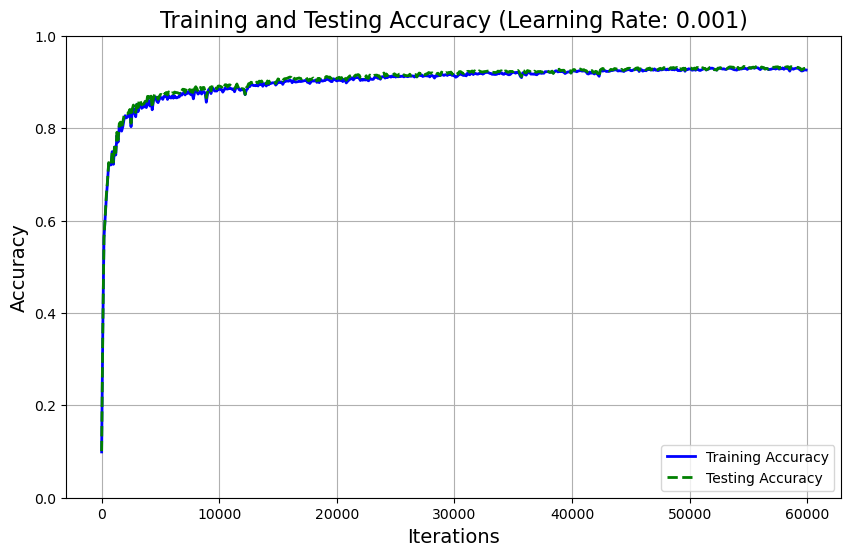


** (org.inkscape.Inkscape:25408): WARNING **: 15:56:36.652: Duplicate option text ('RGBA 8') for parameter 'png_bitdepth' in extension 'org.inkscape.output.png.inkscape'.


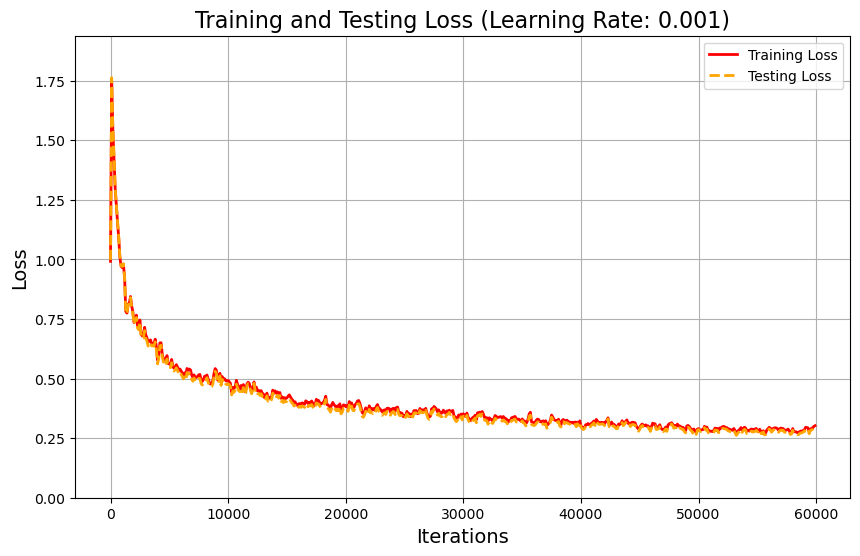

•----- lr 0.01  Iteration 0     ----- Train Accuracy: 0.12   ----- Test Accuracy: 0.13   ----- Train Loss: 1.52   ----- Test Loss: 1.52   -----•
•----- lr 0.01  Iteration 100   ----- Train Accuracy: 0.60   ----- Test Accuracy: 0.60   ----- Train Loss: 1.37   ----- Test Loss: 1.39   -----•
•----- lr 0.01  Iteration 200   ----- Train Accuracy: 0.70   ----- Test Accuracy: 0.70   ----- Train Loss: 1.04   ----- Test Loss: 1.04   -----•
•----- lr 0.01  Iteration 300   ----- Train Accuracy: 0.70   ----- Test Accuracy: 0.71   ----- Train Loss: 0.94   ----- Test Loss: 0.94   -----•
•----- lr 0.01  Iteration 400   ----- Train Accuracy: 0.76   ----- Test Accuracy: 0.76   ----- Train Loss: 0.86   ----- Test Loss: 0.85   -----•
•----- lr 0.01  Iteration 500   ----- Train Accuracy: 0.73   ----- Test Accuracy: 0.72   ----- Train Loss: 0.85   ----- Test Loss: 0.85   -----•
•----- lr 0.01  Iteration 600   ----- Train Accuracy: 0.80   ----- Test Accuracy: 0.80   ----- Train Loss: 0.76   ----- Test Loss:


** (org.inkscape.Inkscape:33115): WARNING **: 16:20:33.522: Duplicate option text ('RGBA 8') for parameter 'png_bitdepth' in extension 'org.inkscape.output.png.inkscape'.


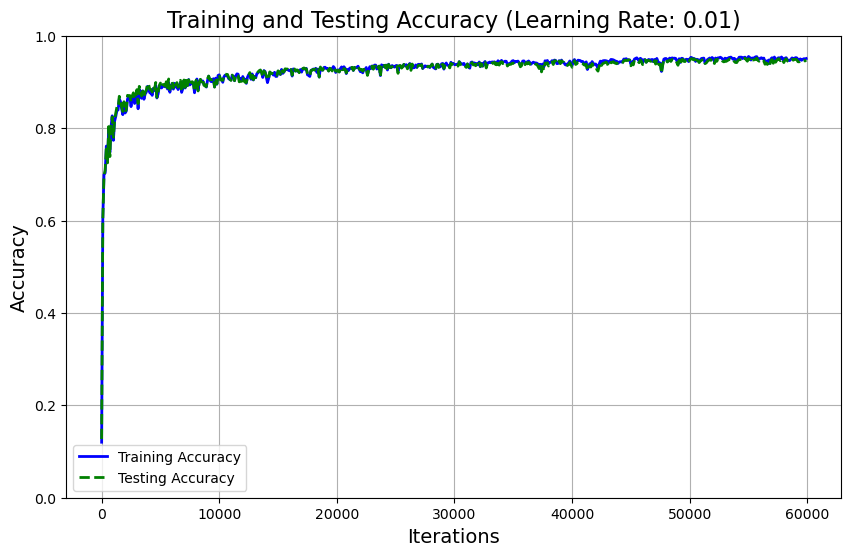


** (org.inkscape.Inkscape:33131): WARNING **: 16:20:34.009: Duplicate option text ('RGBA 8') for parameter 'png_bitdepth' in extension 'org.inkscape.output.png.inkscape'.


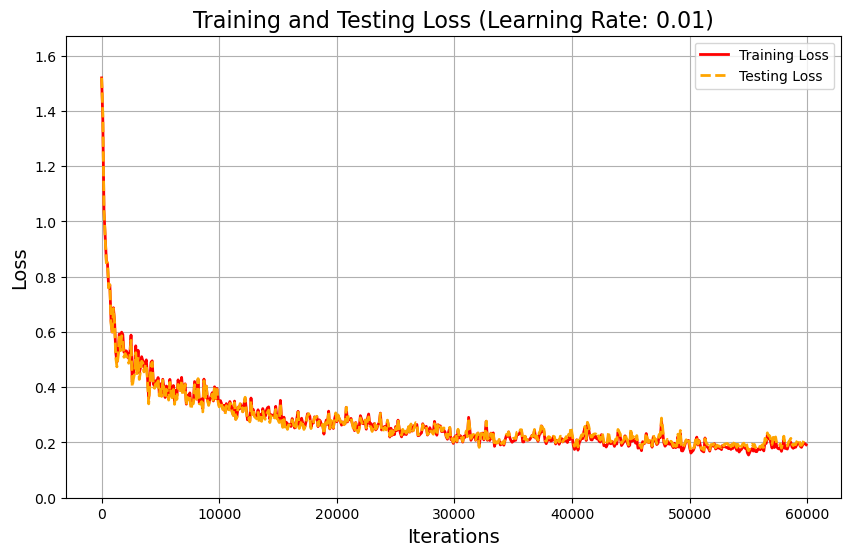

•----- lr 0.1   Iteration 0     ----- Train Accuracy: 0.09   ----- Test Accuracy: 0.09   ----- Train Loss: 1.95   ----- Test Loss: 1.96   -----•
•----- lr 0.1   Iteration 100   ----- Train Accuracy: 0.57   ----- Test Accuracy: 0.56   ----- Train Loss: 1.47   ----- Test Loss: 1.51   -----•
•----- lr 0.1   Iteration 200   ----- Train Accuracy: 0.70   ----- Test Accuracy: 0.70   ----- Train Loss: 1.09   ----- Test Loss: 1.10   -----•
•----- lr 0.1   Iteration 300   ----- Train Accuracy: 0.71   ----- Test Accuracy: 0.72   ----- Train Loss: 1.02   ----- Test Loss: 1.01   -----•
•----- lr 0.1   Iteration 400   ----- Train Accuracy: 0.76   ----- Test Accuracy: 0.76   ----- Train Loss: 0.92   ----- Test Loss: 0.91   -----•
•----- lr 0.1   Iteration 500   ----- Train Accuracy: 0.70   ----- Test Accuracy: 0.70   ----- Train Loss: 0.99   ----- Test Loss: 0.99   -----•
•----- lr 0.1   Iteration 600   ----- Train Accuracy: 0.79   ----- Test Accuracy: 0.79   ----- Train Loss: 0.85   ----- Test Loss:


** (org.inkscape.Inkscape:41673): WARNING **: 16:47:39.909: Duplicate option text ('RGBA 8') for parameter 'png_bitdepth' in extension 'org.inkscape.output.png.inkscape'.


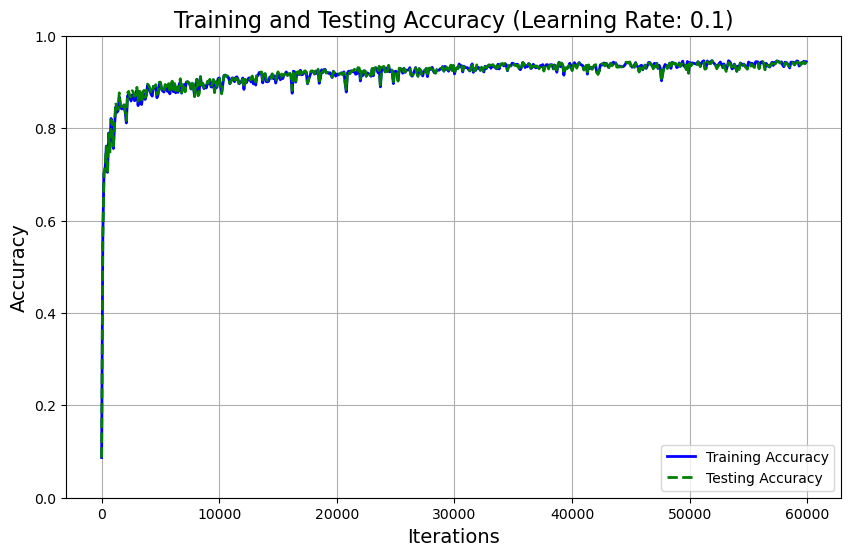


** (org.inkscape.Inkscape:41695): WARNING **: 16:47:40.682: Duplicate option text ('RGBA 8') for parameter 'png_bitdepth' in extension 'org.inkscape.output.png.inkscape'.


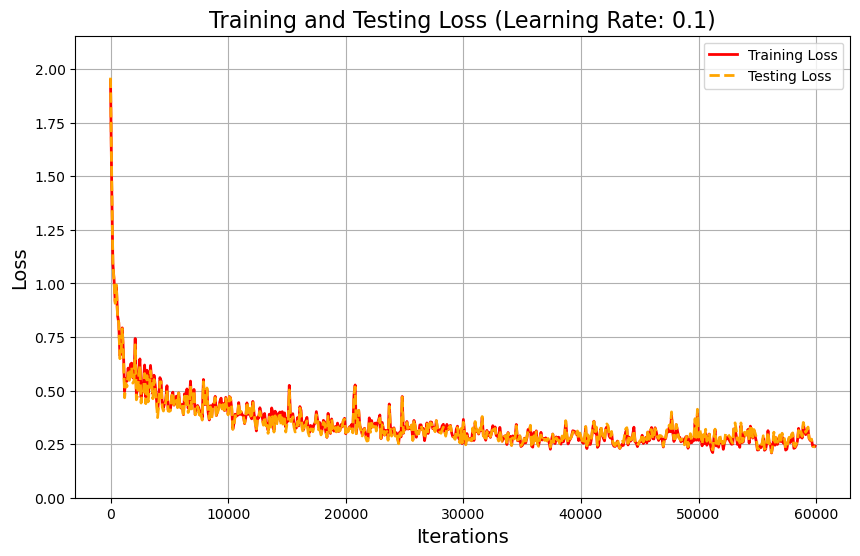

In [41]:
# train at different learning rates
train_mlp(0.001)
train_mlp(0.01)
train_mlp(0.1)